## Load Packages

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pprint
import pickle

import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import pyspark
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType, BooleanType

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.base import BaseEstimator, TransformerMixin

import xgboost as xgb

/usr/local/lib/python3.12/site-packages/xgboost/compat.py:105: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Build a .py script that takes a snapshot date, trains a model and outputs artefact into storage.

## set up pyspark session

In [2]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("model_train_main") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/24 04:49:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## preliminary planning

With 12 months train-test with OOT 2 months, I intially proposed model_train_date_str to be 1/1/2023 + 14 months = 1/3/2024

In [3]:
# set up config
model_train_date_str = "2024-03-01"
train_test_period_months = 12
oot_period_months = 2
train_test_ratio = 0.8

config = {}
config["model_train_date_str"] = model_train_date_str
config["train_test_period_months"] = train_test_period_months
config["oot_period_months"] =  oot_period_months
config["model_train_date"] =  datetime.strptime(model_train_date_str, "%Y-%m-%d")
config["oot_end_date"] =  config['model_train_date'] - timedelta(days = 1)
config["oot_start_date"] =  config['model_train_date'] - relativedelta(months = oot_period_months)
config["train_test_end_date"] =  config["oot_start_date"] - timedelta(days = 1)
config["train_test_start_date"] =  config["oot_start_date"] - relativedelta(months = train_test_period_months)
config["train_test_ratio"] = train_test_ratio 


pprint.pprint(config)

{'model_train_date': datetime.datetime(2024, 3, 1, 0, 0),
 'model_train_date_str': '2024-03-01',
 'oot_end_date': datetime.datetime(2024, 2, 29, 0, 0),
 'oot_period_months': 2,
 'oot_start_date': datetime.datetime(2024, 1, 1, 0, 0),
 'train_test_end_date': datetime.datetime(2023, 12, 31, 0, 0),
 'train_test_period_months': 12,
 'train_test_ratio': 0.8,
 'train_test_start_date': datetime.datetime(2023, 1, 1, 0, 0)}


In [9]:
# connect to label store
folder_path = "datamart/gold/label_store/"
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
label_store_sdf = spark.read.parquet(*files_list)
print("row_count:",label_store_sdf.count())

label_store_sdf.show()

row_count: 8974
+--------------------+-----------+-----+----------+-------------+
|             loan_id|Customer_ID|label| label_def|snapshot_date|
+--------------------+-----------+-----+----------+-------------+
|CUS_0x1037_2023_0...| CUS_0x1037|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1069_2023_0...| CUS_0x1069|    0|30dpd_6mob|   2023-07-01|
|CUS_0x114a_2023_0...| CUS_0x114a|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1184_2023_0...| CUS_0x1184|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1297_2023_0...| CUS_0x1297|    1|30dpd_6mob|   2023-07-01|
|CUS_0x12fb_2023_0...| CUS_0x12fb|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1325_2023_0...| CUS_0x1325|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1341_2023_0...| CUS_0x1341|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1375_2023_0...| CUS_0x1375|    1|30dpd_6mob|   2023-07-01|
|CUS_0x13a8_2023_0...| CUS_0x13a8|    0|30dpd_6mob|   2023-07-01|
|CUS_0x13ef_2023_0...| CUS_0x13ef|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1440_2023_0...| CUS_0x1440|    0|30dpd_6mob|   2023-0

Insights: Since the earliest loan_start_date in the dataset is 1/1/2023, the earliest label only generated on **1/7/2023**. This is shown in the above table

In [10]:
# extract label store
labels_sdf = label_store_sdf.filter((col("snapshot_date") >= config["train_test_start_date"]) & (col("snapshot_date") <= config["oot_end_date"]))

print("extracted labels_sdf rows:", labels_sdf.count())
print("train_test_start_date: ", config["train_test_start_date"])
print("oot_end_date: ", config["oot_end_date"])

extracted labels_sdf rows: 4037
train_test_start_date:  2023-01-01 00:00:00
oot_end_date:  2024-02-29 00:00:00


In [12]:
labels_sdf.select("snapshot_date").distinct().orderBy("snapshot_date").collect()

[Row(snapshot_date=datetime.date(2023, 7, 1)),
 Row(snapshot_date=datetime.date(2023, 8, 1)),
 Row(snapshot_date=datetime.date(2023, 9, 1)),
 Row(snapshot_date=datetime.date(2023, 10, 1)),
 Row(snapshot_date=datetime.date(2023, 11, 1)),
 Row(snapshot_date=datetime.date(2023, 12, 1)),
 Row(snapshot_date=datetime.date(2024, 1, 1)),
 Row(snapshot_date=datetime.date(2024, 2, 1))]

Insights: Since labels are only generated from 1/7/2023, given a model config as such:  
```python
{'model_train_date': datetime.datetime(2024, 3, 1, 0, 0),
 'model_train_date_str': '2024-03-01',
 'oot_end_date': datetime.datetime(2024, 2, 29, 0, 0),
 'oot_period_months': 2,
 'oot_start_date': datetime.datetime(2024, 1, 1, 0, 0),
 'train_test_end_date': datetime.datetime(2023, 12, 31, 0, 0),
 'train_test_period_months': 12,
 'train_test_ratio': 0.8,
 'train_test_start_date': datetime.datetime(2023, 1, 1, 0, 0)}
 ```  

In our train_test_start_date to oot_end_date, we only have data from 1/7/2023 - 1/2/2024 (8 months).  

The recommended no. of data for credit risk models based on industry (e.g. SAS) is 12 months to capture all seasonalities. With 2 months OOT, we need 14 months of data.   

**Findings: Therefore, 01-03-2024 is not feasible as a model_train_date. To push the model_train_date 6 months back to 01-09-2024.** 

## set up config

In [3]:
# set up config
model_train_date_str = "2024-09-01"
train_test_period_months = 12
oot_period_months = 2
train_test_ratio = 0.8

config = {}
config["model_train_date_str"] = model_train_date_str
config["train_test_period_months"] = train_test_period_months
config["oot_period_months"] =  oot_period_months
config["model_train_date"] =  datetime.strptime(model_train_date_str, "%Y-%m-%d")
config["oot_end_date"] =  config['model_train_date'] - timedelta(days = 1)
config["oot_start_date"] =  config['model_train_date'] - relativedelta(months = oot_period_months)
config["train_test_end_date"] =  config["oot_start_date"] - timedelta(days = 1)
config["train_test_start_date"] =  config["oot_start_date"] - relativedelta(months = train_test_period_months)
config["train_test_ratio"] = train_test_ratio 

pprint.pprint(config)

{'model_train_date': datetime.datetime(2024, 9, 1, 0, 0),
 'model_train_date_str': '2024-09-01',
 'oot_end_date': datetime.datetime(2024, 8, 31, 0, 0),
 'oot_period_months': 2,
 'oot_start_date': datetime.datetime(2024, 7, 1, 0, 0),
 'train_test_end_date': datetime.datetime(2024, 6, 30, 0, 0),
 'train_test_period_months': 12,
 'train_test_ratio': 0.8,
 'train_test_start_date': datetime.datetime(2023, 7, 1, 0, 0)}


## get label store

In [4]:
# connect to label store
folder_path = "datamart/gold/label_store/"
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
label_store_sdf = spark.read.parquet(*files_list)
print("row_count:",label_store_sdf.count())

label_store_sdf.show()

row_count: 8974
+--------------------+-----------+-----+----------+-------------+
|             loan_id|Customer_ID|label| label_def|snapshot_date|
+--------------------+-----------+-----+----------+-------------+
|CUS_0x1037_2023_0...| CUS_0x1037|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1069_2023_0...| CUS_0x1069|    0|30dpd_6mob|   2023-07-01|
|CUS_0x114a_2023_0...| CUS_0x114a|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1184_2023_0...| CUS_0x1184|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1297_2023_0...| CUS_0x1297|    1|30dpd_6mob|   2023-07-01|
|CUS_0x12fb_2023_0...| CUS_0x12fb|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1325_2023_0...| CUS_0x1325|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1341_2023_0...| CUS_0x1341|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1375_2023_0...| CUS_0x1375|    1|30dpd_6mob|   2023-07-01|
|CUS_0x13a8_2023_0...| CUS_0x13a8|    0|30dpd_6mob|   2023-07-01|
|CUS_0x13ef_2023_0...| CUS_0x13ef|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1440_2023_0...| CUS_0x1440|    0|30dpd_6mob|   2023-0

In [5]:
# extract label store
labels_sdf = label_store_sdf.filter((col("snapshot_date") >= config["train_test_start_date"]) & (col("snapshot_date") <= config["oot_end_date"]))

print("extracted labels_sdf rows:", labels_sdf.count())
print("train_test_start_date: ", config["train_test_start_date"])
print("oot_end_date: ", config["oot_end_date"])

[Stage 5:===================>                                      (4 + 8) / 12]

extracted labels_sdf rows: 6961
train_test_start_date:  2023-07-01 00:00:00
oot_end_date:  2024-08-31 00:00:00


In [6]:
# Verify that there is enough training data
labels_sdf.select("snapshot_date").distinct().orderBy("snapshot_date").collect()

[Row(snapshot_date=datetime.date(2023, 7, 1)),
 Row(snapshot_date=datetime.date(2023, 8, 1)),
 Row(snapshot_date=datetime.date(2023, 9, 1)),
 Row(snapshot_date=datetime.date(2023, 10, 1)),
 Row(snapshot_date=datetime.date(2023, 11, 1)),
 Row(snapshot_date=datetime.date(2023, 12, 1)),
 Row(snapshot_date=datetime.date(2024, 1, 1)),
 Row(snapshot_date=datetime.date(2024, 2, 1)),
 Row(snapshot_date=datetime.date(2024, 3, 1)),
 Row(snapshot_date=datetime.date(2024, 4, 1)),
 Row(snapshot_date=datetime.date(2024, 5, 1)),
 Row(snapshot_date=datetime.date(2024, 6, 1)),
 Row(snapshot_date=datetime.date(2024, 7, 1)),
 Row(snapshot_date=datetime.date(2024, 8, 1))]

## get features

We will not take features from gold engagement table (contains last 1-6 months of clickstream) as it was proven in exploratory data analysis in Assignment 1 that the clickstream behaviour had very low correlation with target (i.e. loan default)

We will also not take features from gold cust_fin_risk table, which is meant for business team reporting purposes. Reason being we want to take the un-aggregated cleaned up features for experimentation.

We will take features from the silver attributes and silver financials table, and do model specific treatment (e.g. one hot encoding, normalisation etc)

Features from silver attributes table

In [7]:
# connect to silver attributes table
folder_path = "datamart/silver/attr/"
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
attributes_sdf = spark.read.parquet(*files_list)
print("row_count:",attributes_sdf.count())

attributes_sdf.show(5)

row_count: 11974
+-----------+-----------+---+-----------+------------+-------------+
|Customer_ID|       Name|Age|        SSN|  Occupation|snapshot_date|
+-----------+-----------+---+-----------+------------+-------------+
| CUS_0x10ac|      Zhouy| 29|780-50-4730|   Developer|   2024-08-01|
| CUS_0x10c5|      Moony| 24|041-74-6785|        NULL|   2024-08-01|
| CUS_0x1145|Blenkinsopr| 24|426-31-9194|     Teacher|   2024-08-01|
| CUS_0x11ac|  Liana B.v| 26|835-92-7751|  Journalist|   2024-08-01|
| CUS_0x122c| Papadimasf| 48|883-73-9594|Entrepreneur|   2024-08-01|
+-----------+-----------+---+-----------+------------+-------------+
only showing top 5 rows



In [8]:
# extract relevant data (data up till oot_end_date) from attributes silver table
# Attributes are collected upon loan application, so filtering from train_test_start_date is incorrect
# Just need to take data up to the oot_end_date
attributes_sdf_subset = attributes_sdf.filter(col("snapshot_date") <= config["oot_end_date"])

print(f"extracted attributes_sdf_subset rows up to {config["oot_end_date"]}:", attributes_sdf_subset.count())

extracted attributes_sdf_subset rows up to 2024-08-31 00:00:00: 10022


In [9]:
# take only important features
attributes_cols = ['Customer_ID', 'Age', 'Occupation']
attributes_sdf_subset = attributes_sdf_subset[attributes_cols]
attributes_sdf_subset.show(5)

+-----------+---+------------+
|Customer_ID|Age|  Occupation|
+-----------+---+------------+
| CUS_0x10ac| 29|   Developer|
| CUS_0x10c5| 24|        NULL|
| CUS_0x1145| 24|     Teacher|
| CUS_0x11ac| 26|  Journalist|
| CUS_0x122c| 48|Entrepreneur|
+-----------+---+------------+
only showing top 5 rows



Features from financials table

In [10]:
# connect to silver financials table
folder_path = "datamart/silver/fin/"
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
financials_sdf = spark.read.parquet(*files_list)
print("row_count:",financials_sdf.count())

financials_sdf.show(5)

row_count: 11974
+-----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+-----------------+---------------+-------------+------------+---------------------+-------------------+--------------------+-----------------+-----------+
|Customer_ID|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|Payment_Behaviour|Monthly_Balance|snapshot_date|Num_Fin_Pdts|Loans_per_Credit_Item|     Debt_to_Salary|       EMI_to_Salar

In [11]:
# extract relevant data (data up till oot_end_date) from silver financials table
# Financials are also collected upon loan application, so filtering from train_test_start_date is incorrect
# Just need to take data up to the oot_end_date
financials_sdf_subset = financials_sdf.filter(col("snapshot_date") <= config["oot_end_date"])

print(f"extracted financials_sdf_subset rows up to {config['oot_end_date']}:", financials_sdf_subset.count())

extracted financials_sdf_subset rows up to 2024-08-31 00:00:00: 10022


In [12]:
# take only important features
financials_cols = [
    'Customer_ID', 'Annual_Income', 'Monthly_Inhand_Salary',
    'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
    'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
    'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
    'Total_EMI_per_month', 'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
    'Num_Fin_Pdts', 'Loans_per_Credit_Item', 'Debt_to_Salary', 'EMI_to_Salary', 'Repayment_Ability', 'Loan_Extent'
]
financials_sdf_subset = financials_sdf_subset[financials_cols]
financials_sdf_subset.show(5)

+-----------+-------------+---------------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+-------------------+-----------------------+-----------------+---------------+------------+---------------------+-------------------+--------------------+-----------------+-----------+
|Customer_ID|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Total_EMI_per_month|Amount_invested_monthly|Payment_Behaviour|Monthly_Balance|Num_Fin_Pdts|Loans_per_Credit_Item|     Debt_to_Salary|       EMI_to_Salary|Repayment_Ability|Loan_Extent|
+-----------+-------------+---------------------+-----------------+---------------+-------------+-

## prepare data for modeling

In [13]:
# Merge label data to attributes and financials into 1 table
merged_df = labels_sdf.select([col(c) for c in labels_sdf.columns]) # make a fresh copy
merged_df = merged_df.join(attributes_sdf_subset, on="Customer_ID", how="left")
merged_df = merged_df.join(financials_sdf_subset, on="Customer_ID", how="left")

# Check size of resultant table. Join is correct, no of rows same as original labels_sdf
print(f"Num of rows: {merged_df.count()}")

Num of rows: 6961


In [14]:
# Convert to Python pandas, prepare data for modeling
merged_df = merged_df.toPandas()
merged_df

,Customer_ID,loan_id,label,label_def,snapshot_date,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Num_Fin_Pdts,Loans_per_Credit_Item,Debt_to_Salary,EMI_to_Salary,Repayment_Ability,Loan_Extent
0,CUS_0x1037,CUS_0x1037_2023_01_01,0,30dpd_6mob,2023-07-01,45.0,Accountant,15989.085,1086.424,5,...,33.797,80.465,0.0,284.380,13,0.400000,0.612291,0.031080,1052.627,52
1,CUS_0x1069,CUS_0x1069_2023_01_01,0,30dpd_6mob,2023-07-01,32.0,Accountant,58637.340,4799.445,4,...,139.885,165.211,3.0,434.849,19,0.818182,0.043496,0.029140,4659.560,81
2,CUS_0x114a,CUS_0x114a_2023_01_01,0,30dpd_6mob,2023-07-01,43.0,Developer,15305.460,1230.455,0,...,20.302,64.778,0.0,327.965,9,0.250000,0.521676,0.016486,1210.153,28
3,CUS_0x1184,CUS_0x1184_2023_01_01,0,30dpd_6mob,2023-07-01,49.0,Lawyer,19867.475,1396.623,3,...,42.607,23.461,NaN,313.594,11,0.333333,0.506066,0.030485,1354.016,30
4,CUS_0x1297,CUS_0x1297_2023_01_01,1,30dpd_6mob,2023-07-01,46.0,Manager,57738.060,4881.505,9,...,296.284,53.821,4.0,388.045,26,0.500000,0.802144,0.060683,4585.221,549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6956,CUS_0xdf6,CUS_0xdf6_2023_09_01,0,30dpd_6mob,2024-03-01,55.0,Mechanic,40453.850,2772.811,2,...,323.343,245.687,0.0,353.928,4,0.000000,0.163804,0.116570,2449.468,0
6957,CUS_0xe23,CUS_0xe23_2023_09_01,0,30dpd_6mob,2024-03-01,39.0,Musician,17815.585,1427.632,8,...,13.347,69.659,1.0,339.758,15,0.066667,0.687812,0.009343,1414.285,25
6958,CUS_0xe4e,CUS_0xe4e_2023_09_01,0,30dpd_6mob,2024-03-01,22.0,Scientist,108073.680,8738.140,3,...,0.000,366.555,4.0,757.259,6,0.000000,0.151417,0.000000,8738.140,0
6959,CUS_0xedd,CUS_0xedd_2023_09_01,0,30dpd_6mob,2024-03-01,NaN,Engineer,125468.440,10445.703,4,...,338.092,590.021,3.0,376.457,12,0.444444,0.108824,0.032364,10107.611,72


In [15]:
merged_df.columns

Index(['Customer_ID', 'loan_id', 'label', 'label_def', 'snapshot_date', 'Age',
       'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Num_Fin_Pdts', 'Loans_per_Credit_Item', 'Debt_to_Salary',
       'EMI_to_Salary', 'Repayment_Ability', 'Loan_Extent'],
      dtype='object')

In [16]:
# After merging successfully, remove Customer_ID (join key) as it is not a feature
# Remove also some descriptive columns (not features)
merged_df_clean = merged_df.drop(columns=['Customer_ID','loan_id', 'label_def'])

In [17]:
merged_df_clean.columns

Index(['label', 'snapshot_date', 'Age', 'Occupation', 'Annual_Income',
       'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Num_Fin_Pdts', 'Loans_per_Credit_Item', 'Debt_to_Salary',
       'EMI_to_Salary', 'Repayment_Ability', 'Loan_Extent'],
      dtype='object')

In [18]:
# split data into train - test - oot
oot_pdf = merged_df_clean[(merged_df_clean['snapshot_date'] >= config["oot_start_date"].date()) & (merged_df_clean['snapshot_date'] <= config["oot_end_date"].date())]
train_test_pdf = merged_df_clean[(merged_df_clean['snapshot_date'] >= config["train_test_start_date"].date()) & (merged_df_clean['snapshot_date'] <= config["train_test_end_date"].date())]

feature_cols = ['Age', 'Occupation', 'Annual_Income',
       'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance', 
        'Num_Fin_Pdts', 'Loans_per_Credit_Item', 'Debt_to_Salary',
       'EMI_to_Salary', 'Repayment_Ability', 'Loan_Extent']

X_oot = oot_pdf[feature_cols]
y_oot = oot_pdf["label"]
X_train, X_test, y_train, y_test = train_test_split(
    train_test_pdf[feature_cols], train_test_pdf["label"], 
    test_size= 1 - config["train_test_ratio"],
    random_state=42,     # Ensures reproducibility
    shuffle=True,        # Shuffle the data before splitting
    stratify=train_test_pdf["label"]           # Stratify based on the label column as target is imbalanced
)

print('X_train', X_train.shape[0])
print('X_test', X_test.shape[0])
print('X_oot', X_oot.shape[0])
print('y_train', y_train.shape[0], round(y_train.mean(),2))
print('y_test', y_test.shape[0], round(y_test.mean(),2))
print('y_oot', y_oot.shape[0], round(y_oot.mean(),2))

X_train

X_train 4766
X_test 1192
X_oot 1003
y_train 4766 0.28
y_test 1192 0.28
y_oot 1003 0.29


,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Num_Fin_Pdts,Loans_per_Credit_Item,Debt_to_Salary,EMI_to_Salary,Repayment_Ability,Loan_Extent
3646,41.0,Manager,8135.855,486.988,7,7,17,9,62,24,...,42.990,14.193,2.0,261.516,23,0.600000,9.394657,0.088096,443.998,558
881,48.0,Media Manager,74437.440,6184.120,5,7,4,2,3,2,...,104.411,351.456,0.0,452.544,14,0.153846,0.071168,0.016881,6079.709,6
3393,51.0,Journalist,30760.150,2639.346,4,10,7,3,28,10,...,41.125,54.683,4.0,418.126,17,0.200000,0.054508,0.015576,2598.221,84
661,38.0,Developer,29777.300,2530.442,10,10,31,5,18,16,...,13088.000,30.083,5.0,357.137,25,0.238095,0.740369,5.170176,-10557.558,90
4925,21.0,Engineer,42888.450,3654.038,5,2,12,1,13,3,...,26.726,41.973,5.0,536.705,8,0.125000,0.035983,0.007312,3627.312,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,50.0,Media Manager,118297.600,10026.133,2,1,9,3,8,0,...,264.093,906.833,NaN,101.687,6,0.750000,0.144291,0.026338,9762.040,24
51,19.0,Accountant,20436.315,1785.026,1,3,7,9,19,1,...,20.366,23.587,4.0,384.549,13,1.800000,0.438835,0.011403,1764.660,171
2996,49.0,Mechanic,19271.825,1905.985,0,4,7,0,11,9,...,0.000,59.272,3.0,391.327,4,0.000000,0.059266,0.000000,1905.985,0
5875,32.0,Mechanic,17455.360,1222.613,7,10,34,7,52,16,...,58.796,80.075,0.0,273.390,24,0.388889,1.354832,0.048051,1163.817,364


## exploratory data analysis (training set only) to guide preprocessing

In [73]:
# Assemble df just for the EDA
train_df = X_train.copy()
train_df['label'] = y_train

In [74]:
train_df.columns

Index(['Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Num_Fin_Pdts', 'Loans_per_Credit_Item', 'Debt_to_Salary',
       'EMI_to_Salary', 'Repayment_Ability', 'Loan_Extent', 'label'],
      dtype='object')

#### Categorical Variables

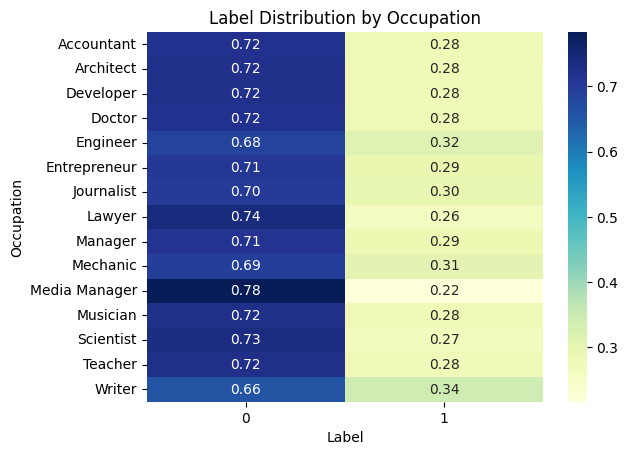

In [45]:
# Occupation field is not useful. % of defaults across all are similar
heat_df = pd.crosstab(train_df['Occupation'], train_df['label'], normalize='index')
sns.heatmap(heat_df, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Label Distribution by Occupation')
plt.xlabel('Label')
plt.ylabel('Occupation')
plt.show()

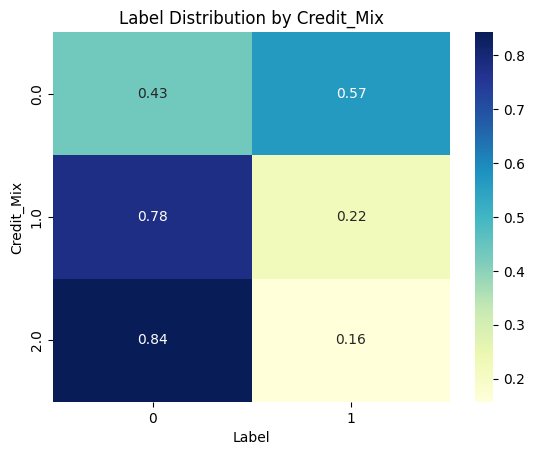

In [48]:
# Bad credit mix (0) has higher probabilty of default, compared to Good (2)
heat_df = pd.crosstab(train_df['Credit_Mix'], train_df['label'], normalize='index')
sns.heatmap(heat_df, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Label Distribution by Credit_Mix')
plt.xlabel('Label')
plt.ylabel('Credit_Mix')
plt.show()

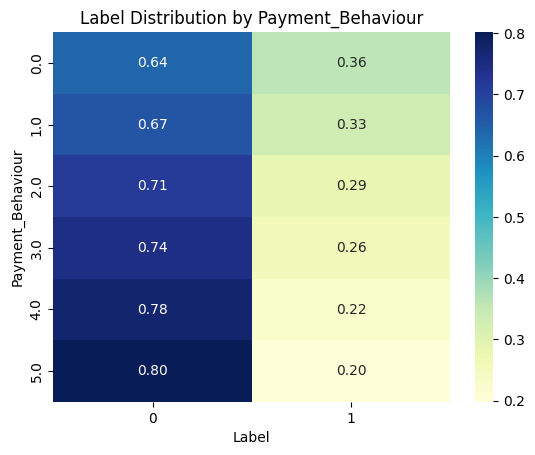

In [49]:
# Payment_Behaviour has somewhat discriminatory power
heat_df = pd.crosstab(train_df['Payment_Behaviour'], train_df['label'], normalize='index')
sns.heatmap(heat_df, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Label Distribution by Payment_Behaviour')
plt.xlabel('Label')
plt.ylabel('Payment_Behaviour')
plt.show()

#### Numerical Variables

In [75]:
numeric_cols = [
    'Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate',
    'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
    'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly',
    'Monthly_Balance', 'Num_Fin_Pdts', 'Loans_per_Credit_Item', 'Debt_to_Salary', 'EMI_to_Salary', 'Repayment_Ability', 'Loan_Extent', 
    'label'
]

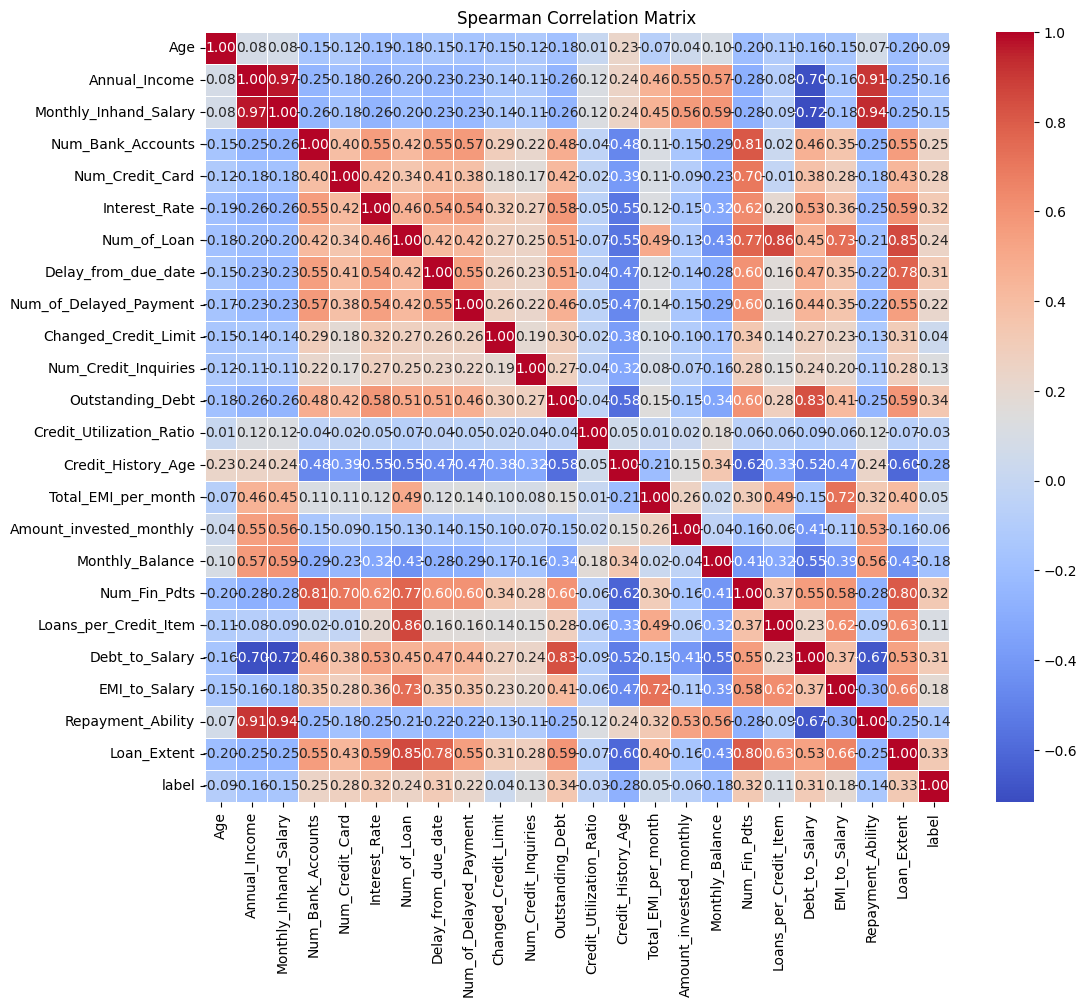

In [76]:
# Calculate Spearman correlation
corr_matrix = train_df[numeric_cols].corr(method='spearman')

# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Spearman Correlation Matrix')
plt.show()

# Positive correlation
## Num_Bank_Accounts
## Num_Credit_Card
## Interest_Rate
## Num_of_Loan
## Delay_from_due_date
## Num_of_Delayed_Payment
## Outstanding_Debt
## Credit_History_Age
## Num_Fin_Pdts
## Debt_to_Salary
## Loan_Extent

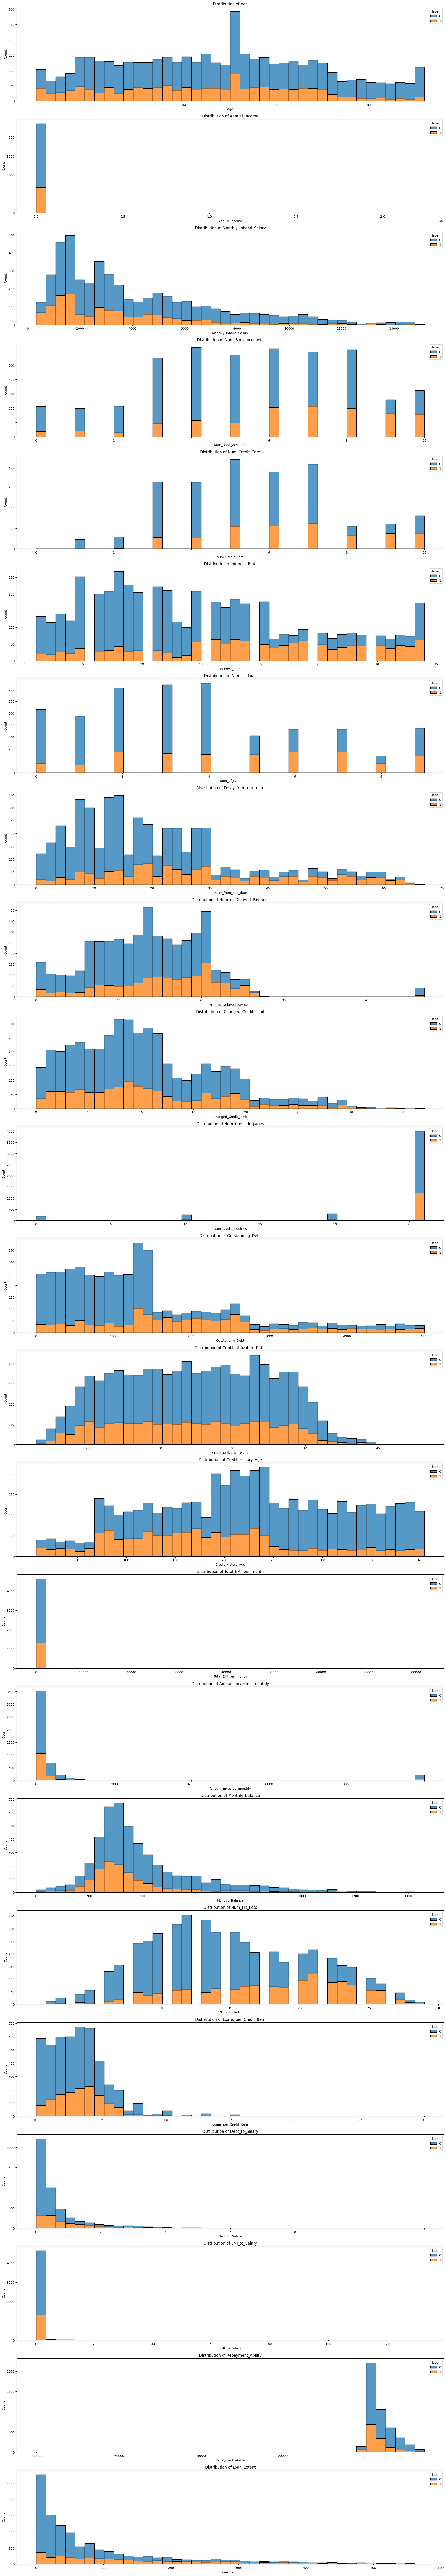

In [77]:
# Explore distributions of numerical features, color coded by target 0 / 1
numeric_cols = [
    'Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate',
    'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
    'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly',
    'Monthly_Balance', 'Num_Fin_Pdts', 'Loans_per_Credit_Item', 'Debt_to_Salary', 'EMI_to_Salary', 'Repayment_Ability', 'Loan_Extent'
]

plt.figure(figsize=(20, 5 * len(numeric_cols)))  # Dynamically scale height

for i, feature in enumerate(numeric_cols):
    plt.subplot(len(numeric_cols), 1, i + 1)  # rows, columns, index
    sns.histplot(data=train_df, x=feature, hue='label', bins=40, multiple='stack')
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

In [80]:
# Check how much to winsorize for Annual_Income (Suggestion 99th percentile)
percentiles = list(range(10, 101, 10))
percentile_values = train_df['Annual_Income'].quantile([p / 100 for p in percentiles])

percentile_table = pd.DataFrame({
    'Percentile': [f"{int(p)}th" for p in percentile_values.index * 100],
    'Annual_Income': percentile_values.values
})

print(percentile_table)

percentiles = list(range(90, 101))
percentile_values = train_df['Annual_Income'].quantile([p / 100 for p in percentiles])

percentile_table = pd.DataFrame({
    'Percentile': [f"{int(p)}th" for p in percentile_values.index * 100],
    'Annual_Income': percentile_values.values
})

print(percentile_table)

  Percentile  Annual_Income
0       10th   1.451612e+04
1       20th   1.780515e+04
2       30th   2.201673e+04
3       40th   3.189507e+04
4       50th   3.832223e+04
5       60th   4.988052e+04
6       70th   6.379263e+04
7       80th   8.116556e+04
8       90th   1.105528e+05
9      100th   2.240988e+07
   Percentile  Annual_Income
0        90th   1.105528e+05
1        91th   1.153655e+05
2        92th   1.198990e+05
3        93th   1.238226e+05
4        94th   1.279499e+05
5        95th   1.324102e+05
6        96th   1.391288e+05
7        97th   1.452954e+05
8        98th   1.653879e+05
9        99th   1.789470e+05
10      100th   2.240988e+07


In [81]:
# Check how much to winsorize for EMI_to_Salary (Suggestion 99th percentile)
percentiles = list(range(10, 101, 10))
percentile_values = train_df['EMI_to_Salary'].quantile([p / 100 for p in percentiles])

percentile_table = pd.DataFrame({
    'Percentile': [f"{int(p)}th" for p in percentile_values.index * 100],
    'EMI_to_Salary': percentile_values.values
})

print(percentile_table)

percentiles = list(range(90, 101))
percentile_values = train_df['EMI_to_Salary'].quantile([p / 100 for p in percentiles])

percentile_table = pd.DataFrame({
    'Percentile': [f"{int(p)}th" for p in percentile_values.index * 100],
    'EMI_to_Salary': percentile_values.values
})

print(percentile_table)

  Percentile  EMI_to_Salary
0       10th       0.000000
1       20th       0.009895
2       30th       0.015936
3       40th       0.020562
4       50th       0.025795
5       60th       0.031876
6       70th       0.040139
7       80th       0.051771
8       90th       0.074868
9      100th     132.869206
   Percentile  EMI_to_Salary
0        90th       0.074868
1        91th       0.079687
2        92th       0.086004
3        93th       0.093213
4        94th       0.110509
5        95th       0.125109
6        96th       0.154861
7        97th       1.237606
8        98th       6.747916
9        99th      15.935517
10      100th     132.869206


## preprocess data

Preprocessing tasks
1. Bin `Interest_Rate` into <= 15 and >15
2. Bin `Credit_History_Age`into <250 and >250
3. One Hot Encoding of `Credit_Mix`, `Payment_Behaviour` (to avoid data leakage)
4. Winsorize outliers in `Annual_Income`, `EMI_to_Salary` (to avoid data leakage)
5. Drop fields with <0.1 correlation (assumed unimportant): `Occupation`, `Age`, `Changed_Credit_Limit`, `Credit_Utilization_Ratio`, `Total_EMI_per_month`, `Amount_invested_monthly`

In [19]:
# Create custom data processing pipeline
class CreditProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # To store clipping thresholds after running fit fxn
        self.annual_income_clip = None
        self.emi_to_salary_clip = None

    def fit(self, X, y=None):
        X = X.copy() # make a copy of X that was passed in safer
        # Get winsorize thresholds for specific features
        self.annual_income_clip = np.percentile(X['Annual_Income'].dropna(), [1, 99])
        self.emi_to_salary_clip = np.percentile(X['EMI_to_Salary'].dropna(), [1, 99])
        return self

    def transform(self, X):
        X = X.copy() # make a copy of X that was passed in safer
        # Drop features
        features_to_drop = ['Occupation', 'Age', 'Changed_Credit_Limit', 'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Amount_invested_monthly']
        X = X.drop(columns=features_to_drop)
        
        # Generate binned features
        X['Is_Interest_Rate_Low'] = (X['Interest_Rate'] <= 15).astype(int)
        X['Is_Credit_History_Age_Low'] = (X['Credit_History_Age'] <= 250).astype(int)

        # Winsorize using fitted thresholds
        X['Annual_Income'] = X['Annual_Income'].clip(
            lower=self.annual_income_clip[0],
            upper=self.annual_income_clip[1]
        )
        X['EMI_to_Salary'] = X['EMI_to_Salary'].clip(
            lower=self.emi_to_salary_clip[0],
            upper=self.emi_to_salary_clip[1]
        )

        # Drop raw columns of binned features
        X = X.drop(columns=['Interest_Rate', 'Credit_History_Age'])
        return X

In [20]:
X_train

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Num_Fin_Pdts,Loans_per_Credit_Item,Debt_to_Salary,EMI_to_Salary,Repayment_Ability,Loan_Extent
3646,41.0,Manager,8135.855,486.988,7,7,17,9,62,24,...,42.990,14.193,2.0,261.516,23,0.600000,9.394657,0.088096,443.998,558
881,48.0,Media Manager,74437.440,6184.120,5,7,4,2,3,2,...,104.411,351.456,0.0,452.544,14,0.153846,0.071168,0.016881,6079.709,6
3393,51.0,Journalist,30760.150,2639.346,4,10,7,3,28,10,...,41.125,54.683,4.0,418.126,17,0.200000,0.054508,0.015576,2598.221,84
661,38.0,Developer,29777.300,2530.442,10,10,31,5,18,16,...,13088.000,30.083,5.0,357.137,25,0.238095,0.740369,5.170176,-10557.558,90
4925,21.0,Engineer,42888.450,3654.038,5,2,12,1,13,3,...,26.726,41.973,5.0,536.705,8,0.125000,0.035983,0.007312,3627.312,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,50.0,Media Manager,118297.600,10026.133,2,1,9,3,8,0,...,264.093,906.833,NaN,101.687,6,0.750000,0.144291,0.026338,9762.040,24
51,19.0,Accountant,20436.315,1785.026,1,3,7,9,19,1,...,20.366,23.587,4.0,384.549,13,1.800000,0.438835,0.011403,1764.660,171
2996,49.0,Mechanic,19271.825,1905.985,0,4,7,0,11,9,...,0.000,59.272,3.0,391.327,4,0.000000,0.059266,0.000000,1905.985,0
5875,32.0,Mechanic,17455.360,1222.613,7,10,34,7,52,16,...,58.796,80.075,0.0,273.390,24,0.388889,1.354832,0.048051,1163.817,364


In [21]:
processor = CreditProcessor()
X_train_clean = processor.fit_transform(X_train)  # thresholds learned here

# Apply cleaning logic to validation and test set
X_test_clean = processor.transform(X_test)           # thresholds reused
X_oot_clean = processor.transform(X_oot)         # thresholds reused

## feature engineering - OHE

In [22]:
# implement one hot encoding manually here to avoid unseen category problem in val/test set
cat_cols = ['Credit_Mix', 'Payment_Behaviour']
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_cat = ohe.fit_transform(X_train_clean[cat_cols])
X_train_cat_df = pd.DataFrame(X_train_cat, columns=ohe.get_feature_names_out(cat_cols), index=X_train_clean.index)
X_train_fe = pd.concat([X_train_clean, X_train_cat_df], axis=1)
X_train_fe = X_train_fe.drop(columns=cat_cols)

In [23]:
# Repeat for X_test_clean, X_oot_clean using the above functions
X_test_cat = ohe.transform(X_test_clean[cat_cols])
X_test_cat_df = pd.DataFrame(X_test_cat, columns=ohe.get_feature_names_out(cat_cols), index=X_test_clean.index)
X_test_fe = pd.concat([X_test_clean, X_test_cat_df], axis=1)
X_test_fe = X_test_fe.drop(columns=cat_cols)

# X_oot_clean
X_oot_cat = ohe.transform(X_oot_clean[cat_cols])
X_oot_cat_df = pd.DataFrame(X_oot_cat, columns=ohe.get_feature_names_out(cat_cols), index=X_oot_clean.index)
X_oot_fe = pd.concat([X_oot_clean, X_oot_cat_df], axis=1)
X_oot_fe = X_oot_fe.drop(columns=cat_cols)

## train model

In [24]:
# Define baseline model
baseline_xgb = xgb.XGBClassifier(
    eval_metric='logloss', 
    random_state=42
)

# Fit on training data
baseline_xgb.fit(X_train_fe, y_train)

# Evaluate on train set
y_train_proba = baseline_xgb.predict_proba(X_train_fe)[:, 1]
train_auc = roc_auc_score(y_train, y_train_proba)

# Evaluate on test set
y_test_proba = baseline_xgb.predict_proba(X_test_fe)[:, 1]
test_auc = roc_auc_score(y_test, y_test_proba)

# Evaluate on OOT set
y_oot_proba = baseline_xgb.predict_proba(X_oot_fe)[:, 1]
oot_auc = roc_auc_score(y_oot, y_oot_proba)

# Print results
print("Baseline Model Performance:")
print(f"Train AUC: {train_auc:.4f} | GINI: {2 * train_auc - 1:.4f}")
print(f"Test AUC: {test_auc:.4f}  | GINI: {2 * test_auc - 1:.4f}")
print(f"OOT AUC: {oot_auc:.4f}   | GINI: {2 * oot_auc - 1:.4f}")

Baseline Model Performance:
Train AUC: 0.9993 | GINI: 0.9986
Test AUC: 0.8030  | GINI: 0.6060
OOT AUC: 0.7821   | GINI: 0.5642


In [25]:
# Define hyperparameter tuned model that was found through random search
# This was done in XGBoost 3.0.0 but due to incompatibility with SKLearn random search, we cant use it here

# Define hyper parameter tuned model with params from XGBoost 3.0.0
best_model = xgb.XGBClassifier(
    colsample_bytree=0.8,
    gamma=0,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=5,
    n_estimators=200,
    reg_alpha=0,
    reg_lambda=2,
    subsample=0.8,
    eval_metric='logloss',
    random_state=42
)

# Fit on training data
best_model.fit(X_train_fe, y_train)

# Evaluate on train set
y_train_proba = best_model.predict_proba(X_train_fe)[:, 1]
train_auc_score = roc_auc_score(y_train, y_train_proba)

# Evaluate on test set
y_test_proba = best_model.predict_proba(X_test_fe)[:, 1]
test_auc_score = roc_auc_score(y_test, y_test_proba)

# Evaluate on OOT set
y_oot_proba = best_model.predict_proba(X_oot_fe)[:, 1]
oot_auc_score = roc_auc_score(y_oot, y_oot_proba)

# Print results
print("Tuned Model Performance (copied from v3.0.0):")
print(f"Train AUC: {train_auc_score:.4f} | GINI: {2 * train_auc_score - 1:.4f}")
print(f"Test AUC: {test_auc_score:.4f}  | GINI: {2 * test_auc_score - 1:.4f}")
print(f"OOT AUC: {oot_auc_score:.4f}   | GINI: {2 * oot_auc_score - 1:.4f}")

Tuned Model Performance (copied from v3.0.0):
Train AUC: 0.8860 | GINI: 0.7720
Test AUC: 0.8185  | GINI: 0.6369
OOT AUC: 0.8036   | GINI: 0.6073


In [24]:
# xgb_clf = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

# param_dist = {
#     'n_estimators': [50, 100, 150, 200],  
#     'max_depth': [3, 5, 6, 8], 
#     'learning_rate': [0.01, 0.1, 0.3], 
#     'subsample': [0.8, 1.0],   
#     'colsample_bytree': [0.8, 1.0], 
#     'gamma': [0, 0.1], 
#     'min_child_weight': [1, 3, 5],  
#     'reg_alpha': [0, 0.1], 
#     'reg_lambda': [1, 2]  
# }

# # Create a scorer based on AUC score
# auc_scorer = make_scorer(roc_auc_score)

# # Set up the random search with cross-validation
# random_search = RandomizedSearchCV(
#     estimator=xgb_clf,
#     param_distributions=param_dist,
#     scoring=auc_scorer,
#     n_iter=20,
#     cv=3,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1 
# )

# # Perform the random search
# random_search.fit(X_train_fe, y_train)

# # Output the best parameters and best score
# print("Best parameters found: ", random_search.best_params_)
# print("Best AUC score: ", random_search.best_score_)

# # save best model
# best_model = random_search.best_estimator_

# # Evaluate the model on the train set
# y_pred_proba = best_model.predict_proba(X_train_fe)[:, 1]
# train_auc_score = roc_auc_score(y_train, y_pred_proba)
# print("Train AUC score: ", train_auc_score)

# # Evaluate the model on the test set
# y_pred_proba = best_model.predict_proba(X_test_fe)[:, 1]
# test_auc_score = roc_auc_score(y_test, y_pred_proba)
# print("Test AUC score: ", test_auc_score)

# # Evaluate the model on the oot set
# y_pred_proba = best_model.predict_proba(X_oot_fe)[:, 1]
# oot_auc_score = roc_auc_score(y_oot, y_pred_proba)
# print("OOT AUC score: ", oot_auc_score)

# print("TRAIN GINI score: ", round(2*train_auc_score-1,3))
# print("Test GINI score: ", round(2*test_auc_score-1,3))
# print("OOT GINI score: ", round(2*oot_auc_score-1,3))

AttributeError: 'super' object has no attribute '__sklearn_tags__'

## prepare model artefact to save

In [26]:
model_artefact = {}

model_artefact['model'] = best_model
model_artefact['model_version'] = "credit_model_"+config["model_train_date_str"].replace('-','_')
model_artefact['preprocessing_transformers'] = {}
model_artefact['preprocessing_transformers']['credit_cleaner'] = processor
model_artefact['preprocessing_transformers']['one_hot_encoder'] = ohe
model_artefact['preprocessing_transformers']['one_hot_encoder_columns'] = cat_cols
model_artefact['data_dates'] = config
model_artefact['data_stats'] = {}
model_artefact['data_stats']['X_train'] = X_train.shape[0]
model_artefact['data_stats']['X_test'] = X_test.shape[0]
model_artefact['data_stats']['X_oot'] = X_oot.shape[0]
model_artefact['data_stats']['y_train'] = round(y_train.mean(),2)
model_artefact['data_stats']['y_test'] = round(y_test.mean(),2)
model_artefact['data_stats']['y_oot'] = round(y_oot.mean(),2)
model_artefact['results'] = {}
model_artefact['results']['auc_train'] = train_auc_score
model_artefact['results']['auc_test'] = test_auc_score
model_artefact['results']['auc_oot'] = oot_auc_score
model_artefact['results']['gini_train'] = round(2*train_auc_score-1,3)
model_artefact['results']['gini_test'] = round(2*test_auc_score-1,3)
model_artefact['results']['gini_oot'] = round(2*oot_auc_score-1,3)
model_artefact['hp_params'] = best_model.get_params()

pprint.pprint(model_artefact)

{'data_dates': {'model_train_date': datetime.datetime(2024, 9, 1, 0, 0),
                'model_train_date_str': '2024-09-01',
                'oot_end_date': datetime.datetime(2024, 8, 31, 0, 0),
                'oot_period_months': 2,
                'oot_start_date': datetime.datetime(2024, 7, 1, 0, 0),
                'train_test_end_date': datetime.datetime(2024, 6, 30, 0, 0),
                'train_test_period_months': 12,
                'train_test_ratio': 0.8,
                'train_test_start_date': datetime.datetime(2023, 7, 1, 0, 0)},
 'data_stats': {'X_oot': 1003,
                'X_test': 1192,
                'X_train': 4766,
                'y_oot': np.float64(0.29),
                'y_test': np.float64(0.28),
                'y_train': np.float64(0.28)},
 'hp_params': {'base_score': 0.5,
               'booster': 'gbtree',
               'callbacks': None,
               'colsample_bylevel': 1,
               'colsample_bynode': 1,
               'colsample_bytree': 0.

## save artefact to model bank

In [27]:
# create model_bank dir
model_bank_directory = "model_bank/"

if not os.path.exists(model_bank_directory):
    os.makedirs(model_bank_directory)

In [28]:
# Full path to the file
file_path = os.path.join(model_bank_directory, model_artefact['model_version'] + '.pkl')

# Write the model to a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(model_artefact, file)

print(f"Model saved to {file_path}")


Model saved to model_bank/credit_model_2024_09_01.pkl


## test load pickle and make model inference

In [29]:
# Load the model from the pickle file
with open(file_path, 'rb') as file:
    loaded_model_artefact = pickle.load(file)

y_pred_proba = loaded_model_artefact['model'].predict_proba(X_oot_fe)[:, 1]
oot_auc_score = roc_auc_score(y_oot, y_pred_proba)
print("OOT AUC score: ", oot_auc_score)

print("Model loaded successfully!")

OOT AUC score:  0.8036410672226727
Model loaded successfully!


## use `model_artefact` to make inference on `train_test_end_date` and save into model_bank as baseline

This will be used for computation of PSI in model_monitoring step

In [31]:
# reformat the date in config["train_test_end_date"]
formatted_date = config["train_test_end_date"].strftime('%Y_%m') + '_01'
formatted_date

'2024_06_01'

In [32]:
# connect to silver attributes table
folder_path = "datamart/silver/attr/"

# read specific parquet file for that train_test_end_date
attributes_sdf = spark.read.parquet(folder_path + 'silver_attr_mthly_' + formatted_date + '.parquet')

# take only important features
attributes_cols = ['Customer_ID', 'Age', 'Occupation', 'snapshot_date']
attributes_sdf_subset = attributes_sdf[attributes_cols]
print("attributes row_count:",attributes_sdf_subset.count())
attributes_sdf_subset.show(5)

attributes row_count: 498
+-----------+----+------------+-------------+
|Customer_ID| Age|  Occupation|snapshot_date|
+-----------+----+------------+-------------+
| CUS_0x10dd|  25|     Teacher|   2024-06-01|
| CUS_0x1109|  43|      Lawyer|   2024-06-01|
| CUS_0x1286|NULL|Entrepreneur|   2024-06-01|
| CUS_0x12a8|  44|      Doctor|   2024-06-01|
| CUS_0x1309|  51|      Writer|   2024-06-01|
+-----------+----+------------+-------------+
only showing top 5 rows



In [33]:
# connect to silver financials table
folder_path = "datamart/silver/fin/"

# read specific parquet file for that train_test_end_date
financials_sdf = spark.read.parquet(folder_path + 'silver_fin_mthly_' + formatted_date + '.parquet')

# take only important features
financials_cols = [
    'Customer_ID', 'Annual_Income', 'Monthly_Inhand_Salary',
    'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
    'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
    'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
    'Total_EMI_per_month', 'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
    'Num_Fin_Pdts', 'Loans_per_Credit_Item', 'Debt_to_Salary', 'EMI_to_Salary', 'Repayment_Ability', 'Loan_Extent'
]
financials_sdf_subset = financials_sdf[financials_cols]
print("financials row_count:",financials_sdf_subset.count())
financials_sdf_subset.show(5)

financials row_count: 498
+-----------+-------------+---------------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+-------------------+-----------------------+-----------------+---------------+------------+---------------------+--------------------+--------------------+-----------------+-----------+
|Customer_ID|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Total_EMI_per_month|Amount_invested_monthly|Payment_Behaviour|Monthly_Balance|Num_Fin_Pdts|Loans_per_Credit_Item|      Debt_to_Salary|       EMI_to_Salary|Repayment_Ability|Loan_Extent|
+-----------+-------------+---------------------+-----------------+---

In [34]:
# Merge attributes and financials into 1 table (no labels at this point in time)
# use inner join coz all customer ID records must have all features from both tables to make inference
merged_df = attributes_sdf_subset.select([col(c) for c in attributes_sdf_subset.columns]) # make a fresh copy of one table
merged_df = merged_df.join(financials_sdf_subset, on="Customer_ID", how="inner")

# Check size of resultant table. 
print(f"merged_df row_count: {merged_df.count()}")

merged_df row_count: 498


In [35]:
# Convert to Python pandas, prepare data for modeling
merged_df = merged_df.toPandas()
merged_df

,Customer_ID,Age,Occupation,snapshot_date,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,...,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Num_Fin_Pdts,Loans_per_Credit_Item,Debt_to_Salary,EMI_to_Salary,Repayment_Ability,Loan_Extent
0,CUS_0x10dd,25.0,Teacher,2024-06-01,105645.600,9090.800,4,3,5,4,...,315.406,170.899,5.0,662.775,11,0.500000,0.147046,0.034691,8775.394,112
1,CUS_0x1109,43.0,Lawyer,2024-06-01,76284.720,6451.060,6,10,18,6,...,222.959,163.649,4.0,508.498,22,0.352941,0.303364,0.034556,6228.101,144
2,CUS_0x1286,NaN,Entrepreneur,2024-06-01,33642.070,2509.506,7,3,12,2,...,29.564,10000.000,4.0,430.549,12,0.181818,0.277462,0.011776,2479.942,44
3,CUS_0x12a8,44.0,Doctor,2024-06-01,103092.270,8311.023,3,6,10,4,...,328.605,65.924,5.0,676.573,13,0.400000,0.036170,0.039534,7982.418,88
4,CUS_0x1309,51.0,Writer,2024-06-01,106876.770,9149.398,4,5,12,1,...,62.243,119.843,5.0,972.854,10,0.100000,0.038913,0.006802,9087.155,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,CUS_0xe51,42.0,Architect,2024-06-01,96583.710,7998.642,5,6,2,1,...,49572.000,64.297,5.0,907.338,12,0.083333,0.097239,6.196777,-41573.358,7
494,CUS_0xe72,43.0,Scientist,2024-06-01,21578.690,1592.224,6,7,17,2,...,18.878,118.506,1.0,301.839,15,0.142857,0.392575,0.011849,1573.346,62
495,CUS_0xea5,28.0,None,2024-06-01,71169.300,6137.775,2,4,5,4,...,212.233,68.135,5.0,573.409,10,0.571429,0.135939,0.034573,5925.542,16
496,CUS_0xf70,33.0,Engineer,2024-06-01,75916.960,6037.413,6,5,14,4,...,27749.000,116.238,5.0,484.250,15,0.333333,0.061041,4.595413,-21711.587,88


In [36]:
# After merging successfully, remove Customer_ID (join key) as it is not a feature
merged_df_clean = merged_df.drop(columns=['Customer_ID', 'snapshot_date'])

In [37]:
# Apply data processing steps from saved transformers
transformer_processor = model_artefact['preprocessing_transformers']['credit_cleaner']
transformer_ohe = model_artefact['preprocessing_transformers']['one_hot_encoder']
cat_cols = model_artefact['preprocessing_transformers']['one_hot_encoder_columns']

# data cleaning
X_inference = transformer_processor.transform(merged_df_clean)

# one hot encoding
X_inference_cat = transformer_ohe.transform(X_inference[cat_cols])
X_inference_cat_df = pd.DataFrame(X_inference_cat, columns=transformer_ohe.get_feature_names_out(cat_cols), index=X_inference.index)
X_inference_fe = pd.concat([X_inference, X_inference_cat_df], axis=1)
X_inference_fe = X_inference_fe.drop(columns=cat_cols)

In [39]:
# load model
model = model_artefact["model"]

# predict model
y_inference = model.predict_proba(X_inference_fe)[:, 1]

# prepare output
y_inference_pdf = merged_df[["Customer_ID","snapshot_date"]].copy()
y_inference_pdf["model_name"] = model_artefact['model_version'] + '.pkl'
y_inference_pdf["model_predictions"] = y_inference
y_inference_pdf

,Customer_ID,snapshot_date,model_name,model_predictions
0,CUS_0x10dd,2024-06-01,credit_model_2024_09_01.pkl,0.146976
1,CUS_0x1109,2024-06-01,credit_model_2024_09_01.pkl,0.596699
2,CUS_0x1286,2024-06-01,credit_model_2024_09_01.pkl,0.082520
3,CUS_0x12a8,2024-06-01,credit_model_2024_09_01.pkl,0.116148
4,CUS_0x1309,2024-06-01,credit_model_2024_09_01.pkl,0.116563
...,...,...,...,...
493,CUS_0xe51,2024-06-01,credit_model_2024_09_01.pkl,0.130320
494,CUS_0xe72,2024-06-01,credit_model_2024_09_01.pkl,0.189973
495,CUS_0xea5,2024-06-01,credit_model_2024_09_01.pkl,0.052733
496,CUS_0xf70,2024-06-01,credit_model_2024_09_01.pkl,0.055120


In [40]:
# save baseline prediction into model_bank 
partition_name = model_artefact['model_version'] + "_psi_ref_preds" + '.parquet'
filepath = model_bank_directory + partition_name

# Convert pandas df to spark df and write to parquet
spark.createDataFrame(y_inference_pdf).write.mode("overwrite").parquet(filepath)
print('PSI baseline prediction saved to:', filepath)

PSI baseline prediction saved to: model_bank/credit_model_2024_09_01_psi_ref_preds.parquet


## close spark session

In [41]:
# end spark session
spark.stop()

print('\n\n---completed job---\n\n')



---completed job---


